## Complete Tiling and Decision Boundary [Part 2]

In [1]:
from manimlib import *
from functools import partial
import sys, cv2 

sys.path.append('../_2025/backprop_3') #Point to folder where plane_folding_utils.py is
sys.path.append('../')
from geometric_dl_utils import *
from geometric_dl_utils_simplified import *
from polytope_intersection_utils import intersect_polytopes
import matplotlib.pyplot as plt

import matplotlib.patches as mp
tab20_colors_mpl = plt.cm.tab20_r.colors

In [2]:
#2x2
# model_path='../models/2_2_1.pth'
# model = BaarleNet([2,2])
# model.load_state_dict(torch.load(model_path))
# viz_scales=[0.25, 0.25, 0.3, 0.3, 0.15]
# num_neurons=[2, 2, 2, 2, 2]

#3x3
# model_path='../models/3_3_1.pth'
# model = BaarleNet([3,3])
# model.load_state_dict(torch.load(model_path))
# viz_scales=[0.1, 0.1, 0.05, 0.05, 0.15]
# num_neurons=[3, 3, 3, 3, 2]

#8x8
model_path='../models/8_8_1.pth'
model = BaarleNet([8,8])
model.load_state_dict(torch.load(model_path))
viz_scales=[0.1, 0.1, 0.05, 0.05, 0.15]
num_neurons=[8, 8, 8, 8, 2]

### 16 16 16
# model_path='../models/16_16_16_1.pth'
# model = BaarleNet([16, 16, 16])
# model.load_state_dict(torch.load(model_path))
# num_neurons=[16, 16, 16, 16, 16, 16, 2]        

### 32 32 32 32
# model_path='../models/32_32_32_32_1.pth'
# model = BaarleNet([32, 32, 32, 32])
# model.load_state_dict(torch.load(model_path))
# num_neurons=[32, 32, 32, 32, 32, 32, 32, 32, 2]        

In [3]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:,:,(2,1,0)]

def viz_descision_boundary(model, res=256, figsize=(6,6)):
    plt.clf()
    fig=plt.figure(0,figsize)
    ax=fig.add_subplot(111)
    
    probe=np.zeros((res,res,2))
    for j, xx in enumerate(np.linspace(-1, 1, res)):
        for k, yy in enumerate(np.linspace(-1, 1, res)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(res**2, -1)
    with torch.no_grad():
        probe_logits=model(torch.tensor(probe).float())
        probe_logits=probe_logits.detach().numpy().reshape(res,res,2)
        probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray', extent=[-1, 1, -1, 1])
    ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
               extent=[-1, 1, -1, 1],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    return ax

In [4]:
def viz_polygon_list(ax, polygon_list, alpha=0.5):
    for j, p in enumerate(polygon_list):    
        if len(p)<3: continue
        poly=mp.Polygon(p[:,:2].tolist(), facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], 
                        edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=alpha)
        ax.add_patch(poly)
    plt.xlim([-1,1]); plt.ylim([-1,1]); ax.axis('off')

def viz_layer_polygons(polygon_list, fig_size=(6,6)):
    '''Assume triple layer list for now'''
    plt.clf()
    fig=plt.figure(0, fig_size)
    sqr=int(np.ceil(np.sqrt(len(polygon_list))))
    for i, pss in enumerate(polygon_list):
        ax=fig.add_subplot(sqr,sqr,i+1)
        for ps in pss: 
            viz_polygon_list(ax, ps)

To Do: 
- Zero region merging
- Top polytope computation and validation
- Put polygon computation in a nice loop that adapts to length

In [5]:
polygons={} #dict of all polygones as we go. 
polygons['-1.new_tiling_unraveled']=[np.array([[-1., -1, 0], #First polygon is just input plane
                                    [-1, 1, 0], 
                                    [1, 1, 0], 
                                    [1, -1, 0]])]

for layer_id in range(len(model.model)//2): #Move polygont through layers     
    polygons[str(layer_id)+'.linear_out']=process_with_layers(model.model[:2*layer_id+1], polygons[str(layer_id-1)+'.new_tiling_unraveled']) 

    #Split polygons w/ Relu and clip to z=0
    polygons[str(layer_id)+'.split_polygons_nested']=split_polygons_with_relu_simple(polygons[str(layer_id)+'.linear_out']) #Triple nested list so we can simplify merging process layer. 
    polygons[str(layer_id)+'.split_polygons_nested_clipped'] = clip_polygons(polygons[str(layer_id)+'.split_polygons_nested'])
    
    polygons[str(layer_id)+'.split_polygons_nested_merged'] = merge_zero_regions_nested(polygons[str(layer_id)+'.split_polygons_nested_clipped'])
    
    polygons[str(layer_id)+'.new_tiling']=recompute_tiling(polygons[str(layer_id)+'.split_polygons_nested_clipped'])
    polygons[str(layer_id)+'.new_tiling_unraveled']=[item for sublist in polygons[str(layer_id)+'.new_tiling'] for item in sublist]

#Last linear layer & output
polygons[str(layer_id+1)+'.linear_out']=process_with_layers(model.model, polygons[str(layer_id)+'.new_tiling_unraveled'])
intersection_lines, new_2d_tiling, upper_polytope, indicator = intersect_polytopes(*polygons[str(layer_id+1)+'.linear_out'])


In [6]:
polygons.keys()

dict_keys(['-1.new_tiling_unraveled', '0.linear_out', '0.split_polygons_nested', '0.split_polygons_nested_clipped', '0.new_tiling', '0.new_tiling_unraveled', '1.linear_out', '1.split_polygons_nested', '1.split_polygons_nested_clipped', '1.new_tiling', '1.new_tiling_unraveled', '2.linear_out'])

In [7]:
polygons['1.split_polygons_nested_merged'] = merge_zero_regions_nested(polygons['1.split_polygons_nested_clipped'])

<Figure size 640x480 with 0 Axes>

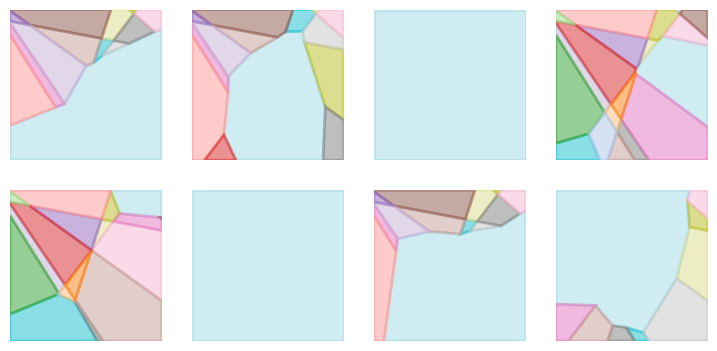

In [10]:
plt.clf()
fig=plt.figure(0, (9,9))
for i, polygons_by_neuron in enumerate(polygons['1.split_polygons_nested_merged']):
    ax=fig.add_subplot(4,4,i+1)
    # unravelled=[item for sublist in polygons_by_neuron for item in sublist]
    viz_polygon_list(ax, polygons_by_neuron)

In [9]:
polygons['1.split_polygons_nested_clipped'][2]

[[array([[ 1.        ,  0.88613825, 16.10489655],
         [-0.3476844 , -0.50462065,  2.10698652],
         [-0.73975797,  1.        , 21.68509674],
         [ 1.        ,  1.        , 17.51534843]])],
 [array([[ 1.        , -1.        ,  0.89295077],
         [ 0.56731292, -1.        ,  0.        ],
         [-0.27474543, -0.7845311 ,  0.        ],
         [-0.3476844 , -0.50462065,  2.10698652],
         [ 1.        ,  0.88613825, 16.10489655]]),
  array([[ 0.56731292, -1.        ,  0.        ],
         [-0.21859861, -1.        ,  0.        ],
         [-0.27474543, -0.7845311 ,  0.        ]])],
 [array([[-0.73975797,  1.        , 21.68509674],
         [-0.3476844 , -0.50462065,  2.10698652],
         [-0.4531214 , -0.61342761,  0.        ],
         [-0.84082759, -0.4739265 ,  0.        ],
         [-1.        , -0.32124362,  1.3699286 ],
         [-1.        ,  1.        , 20.34062195]]),
  array([[-0.4531214 , -0.61342761,  0.        ],
         [-0.5698345 , -0.73387108,  0. 

In [11]:
polygons['1.split_polygons_nested_merged'][1]

[array([[ 0.778622  ,  1.        ,  0.        ],
        [ 1.        ,  1.        ,  0.        ],
        [ 1.        ,  0.64880792,  0.        ],
        [ 0.79678905,  0.71217296,  0.        ],
        [ 0.79678905,  0.71217296,  0.        ],
        [ 0.05401775,  0.07361996,  0.        ],
        [-1.        ,  0.40228276,  0.        ],
        [-1.        ,  1.        ,  0.        ]]),
 array([[-1.        ,  0.40228276,  0.        ],
        [ 0.05401775,  0.07361996,  0.        ],
        [ 0.12178239, -1.        ,  0.        ],
        [-1.        , -1.        ,  0.        ]]),
 array([[ 0.79678905,  0.71217296,  0.        ],
        [ 0.85281462, -0.17546011,  1.31708503],
        [ 0.05401775,  0.07361996,  0.        ]]),
 array([[ 1.        ,  0.64880792,  0.        ],
        [ 1.        , -0.22135531,  1.31708503],
        [ 0.85281462, -0.17546011,  1.31708503],
        [ 0.79678905,  0.71217296,  0.        ]]),
 array([[ 0.05401775,  0.07361996,  0.        ],
        [ 0.

<Figure size 640x480 with 0 Axes>

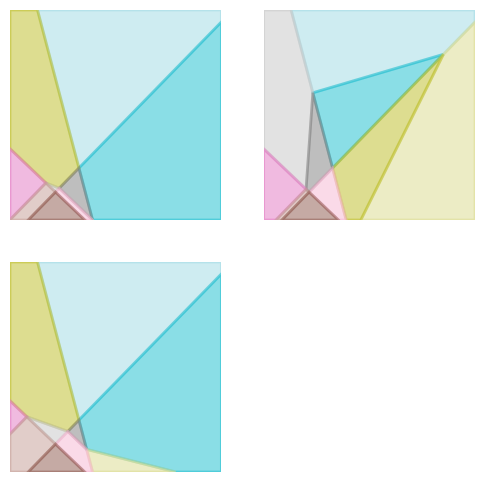

In [16]:
plt.clf()
fig=plt.figure(0, (6,6))
for i, polygons_by_neuron in enumerate(polygons['1.split_polygons_nested']):
    ax=fig.add_subplot(2,2,i+1)
    unravelled=[item for sublist in polygons_by_neuron for item in sublist]
    viz_polygon_list(ax, unravelled)

In [11]:
# polygons['1.split_polygons_nested']

In [12]:
# polygons['1.split_polygons_nested']

In [13]:
# clip_polygons(polygons['1.split_polygons_nested'])

In [15]:
len(polygons['1.split_polygons_nested'])

2

In [16]:
len(polygons['1.split_polygons_nested'][0])

4

In [17]:
polygons['1.split_polygons_nested'][0][0]

[array([[-1.        ,  1.        ,  1.94521189],
        [ 0.778622  ,  1.        ,  0.84517479],
        [ 0.8060058 ,  0.56614863,  0.        ],
        [-0.33746955,  0.19569315,  0.        ],
        [-1.        ,  0.40228276,  0.80414724]]),
 array([[ 0.8060058 ,  0.56614863,  0.        ],
        [ 0.85281462, -0.17546011, -1.44470906],
        [-0.33746955,  0.19569315,  0.        ]])]

In [20]:
polygons['1.split_polygons_nested'][0][3]

[array([[ 1.        , -0.22135531, -1.44470906],
        [ 1.        , -1.        , -1.44470906],
        [ 0.90485789, -1.        , -1.44470906],
        [ 0.85281462, -0.17546011, -1.44470906]])]

In [ ]:
def merge_zero_regions_nested(nested_polygons): 
    '''
    Find adjacent polygons with all z=0 and merge them into a single polygon
    nested_polygons is a list of list of lists of Nx3 numpy arrays, corresponding to individual 3d polygons
    The outer list corresponds to neurons, each neuron should be treated separately in this case
    The next two layers of lists are groupings of polygons - these groupings are not important at this phase, 
    so they should be unrolled into a single list of neurons per layer and then operated on. 
    for each list in the outer loop merge_zero_regions should iterate through all polygons and find all polygons that 
    have z=0 for all vertices and share at least one edge. These polygons should be merged. 
    merge_zero_regions returns a list of list of Nx3 numpy arrays. Outer list length should match outer list length of input list
    '''

<Figure size 640x480 with 0 Axes>

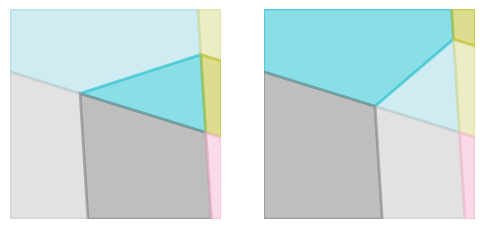

In [14]:
plt.clf()
fig=plt.figure(0, (6,6))
for i, polygons_by_neuron in enumerate(polygons['1.split_polygons_nested']):
    ax=fig.add_subplot(2,2,i+1)
    unravelled=[item for sublist in polygons_by_neuron for item in sublist]
    viz_polygon_list(ax, unravelled)

<Figure size 640x480 with 0 Axes>

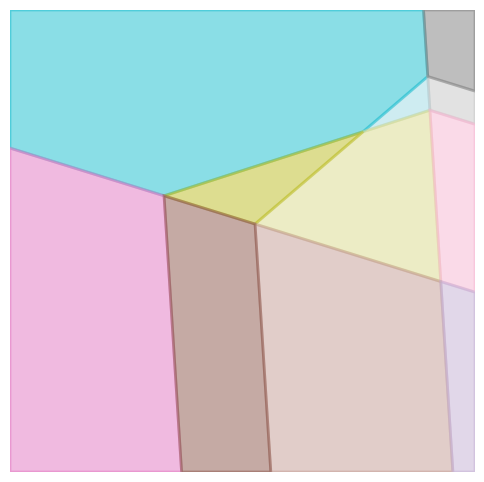

In [15]:
plt.clf()
fig=plt.figure(0, (6,6))
ax=fig.add_subplot(111)
viz_polygon_list(ax, polygons['1.new_tiling_unraveled'])

In [16]:
polygons['0.new_tiling']

[[array([[-1.        ,  1.        ,  0.        ],
         [ 0.778622  ,  1.        ,  0.        ],
         [ 0.85281462, -0.17546011,  0.        ],
         [-1.        ,  0.40228276,  0.        ]]),
  array([[ 1.        ,  1.        ,  0.        ],
         [ 1.        , -0.22135531,  0.        ],
         [ 0.85281462, -0.17546011,  0.        ],
         [ 0.778622  ,  1.        ,  0.        ]]),
  array([[-1.        ,  0.40228276,  0.        ],
         [ 0.85281462, -0.17546011,  0.        ],
         [ 0.90485789, -1.        ,  0.        ],
         [-1.        , -1.        ,  0.        ]]),
  array([[ 1.        , -0.22135531,  0.        ],
         [ 1.        , -1.        ,  0.        ],
         [ 0.90485789, -1.        ,  0.        ],
         [ 0.85281462, -0.17546011,  0.        ]])]]

<Figure size 640x480 with 0 Axes>

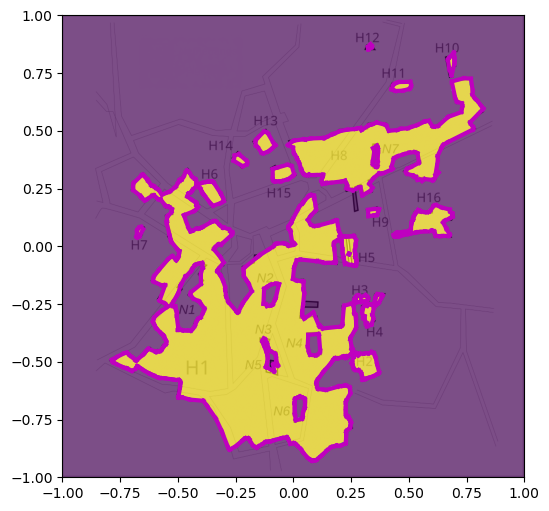

In [23]:
ax=viz_descision_boundary(model)
for l in intersection_lines:
    ax.plot(l[:,0], l[:,1], c='m', linewidth=3)

<Figure size 640x480 with 0 Axes>

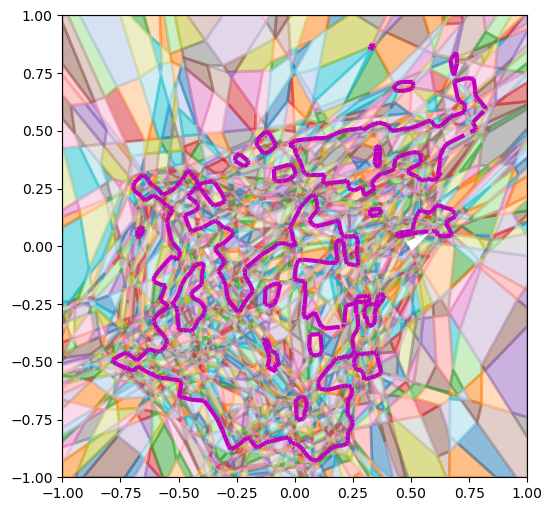

In [24]:
plt.clf()
fig=plt.figure(0, (6,6))
ax=fig.add_subplot(111)
for j, p in enumerate(new_2d_tiling):    
    if len(p)<3: continue
    poly=mp.Polygon(p[:,:2].tolist(), facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], 
                    edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.5)
    ax.add_patch(poly)
for l in intersection_lines:
    ax.plot(l[:,0], l[:,1], 'm--', linewidth=3, )
plt.xlim([-1,1]); plt.ylim([-1,1]);

In [5]:
# # use this data structure all the way through, might just need a little  deviation at the end. 
# # The output of each layer will be a list of list of 3d polygons as Nx3 numpy arrays. The outer list correspond to the 
# # number of nuerons in that layer, and the inner list correspond to the polygons output by each neuron
# # The xy values of each polygon are the same across all neurons
# polygons={} #dict of all polygones as we go. 
# polygons['input_plane']=[np.array([[-1., -1, 0], 
#                                     [-1, 1, 0], 
#                                     [1, 1, 0], 
#                                     [1, -1, 0]])]


# #Ok at some poing in these needs loops I think I need to merge zero regions? Is that really just for viz though? Might need to think about that. 
# polygons['0.linear_out']=process_with_layers(model.model[0], polygons['input_plane']) #Just first layer of model
# polygons['0.split_polygons_nested']=split_polygons_with_relu_simple(polygons['0.linear_out']) #Triple nested list so we can simplify merging process layer. 
# polygons['0.new_tiling']=recompute_tiling(polygons['0.split_polygons_nested'])
# polygons['0.new_tiling_unraveled']=[item for sublist in polygons['0.new_tiling'] for item in sublist]

# #Ok so I think now we repeat
# polygons['1.linear_out']=process_with_layers(model.model[:3], polygons['0.new_tiling_unraveled'])
# polygons['1.split_polygons_nested']=split_polygons_with_relu_simple(polygons['1.linear_out'])
# polygons['1.new_tiling']=recompute_tiling(polygons['1.split_polygons_nested'])
# polygons['1.new_tiling_unraveled']=[item for sublist in polygons['1.new_tiling'] for item in sublist]

# polygons['2.linear_out']=process_with_layers(model.model[:5], polygons['1.new_tiling_unraveled'])
# polygons['2.split_polygons_nested']=split_polygons_with_relu_simple(polygons['2.linear_out'])
# polygons['2.new_tiling']=recompute_tiling(polygons['2.split_polygons_nested'])
# polygons['2.new_tiling_unraveled']=[item for sublist in polygons['2.new_tiling'] for item in sublist]

# polygons['3.linear_out']=process_with_layers(model.model[:7], polygons['2.new_tiling_unraveled'])
# polygons['3.split_polygons_nested']=split_polygons_with_relu_simple(polygons['3.linear_out'])
# polygons['3.new_tiling']=recompute_tiling(polygons['3.split_polygons_nested'])
# polygons['3.new_tiling_unraveled']=[item for sublist in polygons['3.new_tiling'] for item in sublist]

# # Ok let me get to the end here (decision boundary on top of heatmap, and then I'll go back and think about 
# # when/where/how to merge zere regions, and how to capture/viz the nested nature of this stuff! 
# # I think like previous layers become lines basically
# polygons['4.linear_out']=process_with_layers(model.model, polygons['3.new_tiling_unraveled'])

# intersection_lines, new_2d_tiling, upper_polytope, indicator = intersect_polytopes(*polygons['4.linear_out'])

<Figure size 640x480 with 0 Axes>

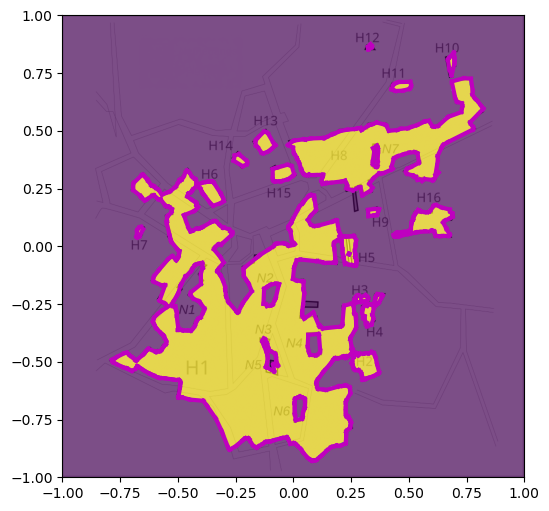

In [6]:
ax=viz_descision_boundary(model)
for l in intersection_lines:
    ax.plot(l[:,0], l[:,1], c='m', linewidth=3)

Fuck yeah its so cool that that actually works lol. 

<Figure size 640x480 with 0 Axes>

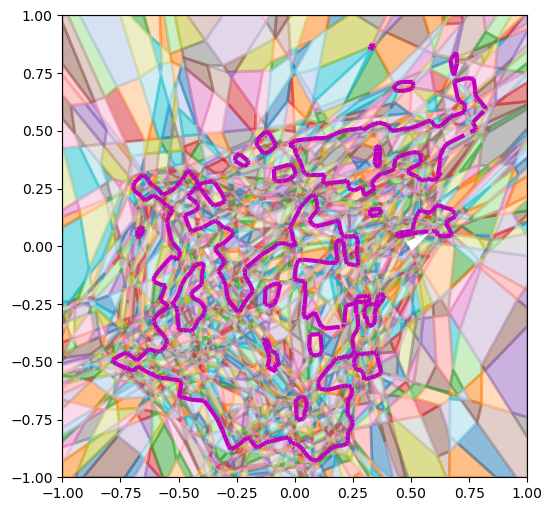

In [7]:
plt.clf()
fig=plt.figure(0, (6,6))
ax=fig.add_subplot(111)
for j, p in enumerate(new_2d_tiling):    
    if len(p)<3: continue
    poly=mp.Polygon(p[:,:2].tolist(), facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], 
                    edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.5)
    ax.add_patch(poly)
for l in intersection_lines:
    ax.plot(l[:,0], l[:,1], 'm--', linewidth=3, )
plt.xlim([-1,1]); plt.ylim([-1,1]);

<Figure size 640x480 with 0 Axes>

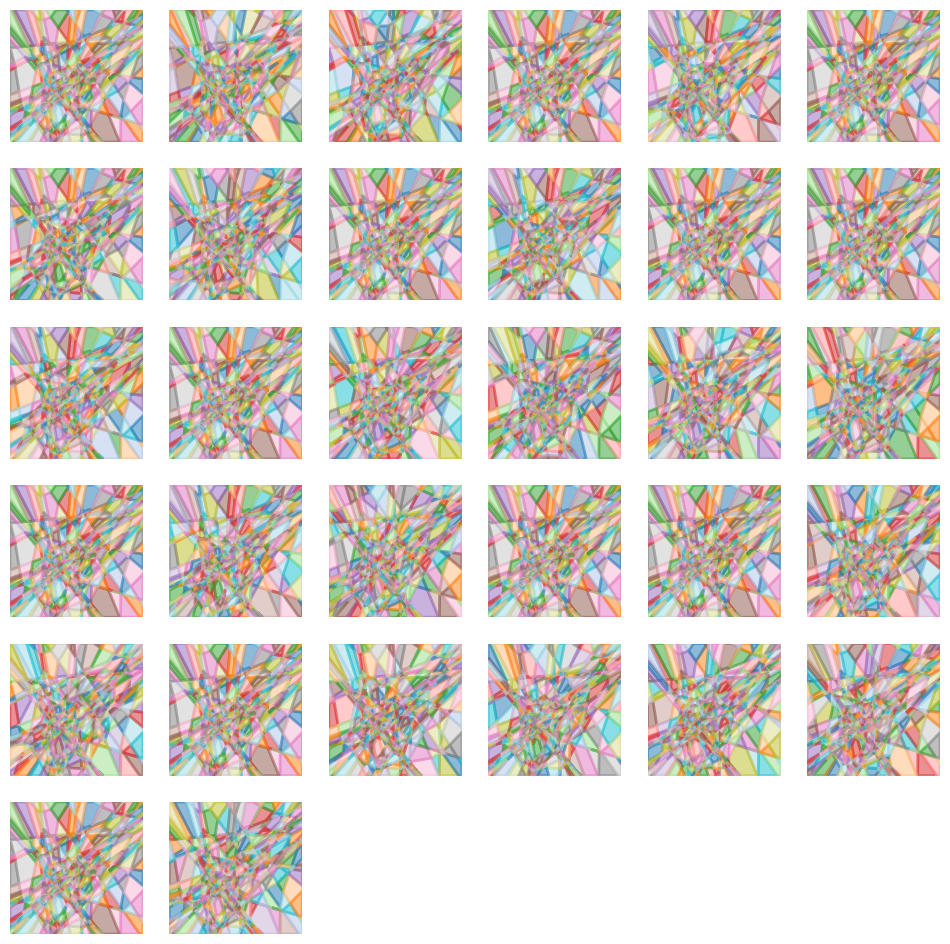

In [9]:
plt.clf()
fig=plt.figure(0, (12,12))
for i, polygons_by_neuron in enumerate(polygons['2.split_polygons_nested']):
    ax=fig.add_subplot(6,6,i+1)
    unravelled=[item for sublist in polygons_by_neuron for item in sublist]
    viz_polygon_list(ax, unravelled)

<Figure size 640x480 with 0 Axes>

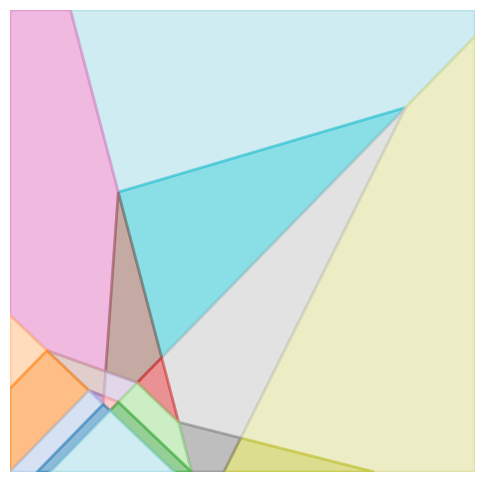

In [72]:
plt.clf()
fig=plt.figure(0, (6,6))
ax=fig.add_subplot(111)
viz_polygon_list(ax, polygons['1.new_tiling_unraveled'])

<Figure size 640x480 with 0 Axes>

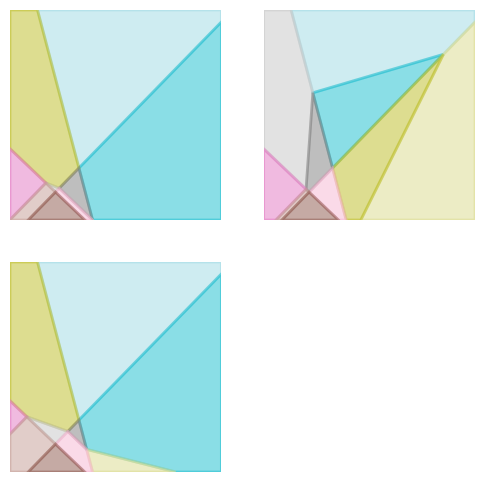

In [70]:
plt.clf()
fig=plt.figure(0, (6,6))
for i, polygons_by_neuron in enumerate(polygons['1.split_polygons_nested']):
    ax=fig.add_subplot(2,2,i+1)
    unravelled=[item for sublist in polygons_by_neuron for item in sublist]
    viz_polygon_list(ax, unravelled)